In [2]:
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
import scipy.io
import matplotlib.animation as animation

from collections import OrderedDict

In [38]:
class DNN(nn.Module):
    def __init__(self):
        super(DNN, self).__init__()
        self.layers = [3, 20, 20, 20, 20, 20, 20, 2] 
        self.depth = len(self.layers) - 1

        self.activation = nn.Tanh

        layer_list = list()
        for i in range(self.depth - 1):
            layer_list.append(('layer_%d' % i, torch.nn.Linear(self.layers[i], self.layers[i+1])))
            layer_list.append(('activation_%d' % i, self.activation()))

        layer_list.append(('layer_%d' % (self.depth - 1), nn.Linear(self.layers[-2], self.layers[-1])))

        layerDict = OrderedDict(layer_list)
        self.model = nn.Sequential(layerDict)
        self.model.apply(self.init_weights)

    # Xavier initilization
    def init_weights(self, m):
        if isinstance(m, nn.Linear):
            nn.init.xavier_uniform_(m.weight)
            nn.init.constant_(m.bias, 0.0)

    def forward(self, x):
        out = self.model(x)
        return out

In [39]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
nu = 0.01/np.pi

class NS:
    def __init__(self, X, Y, T, u, v):
        self.x = torch.tensor(X, dtype=torch.float32, requires_grad=True).to(device)
        self.y = torch.tensor(Y, dtype=torch.float32, requires_grad=True).to(device)
        self.t = torch.tensor(T, dtype=torch.float32, requires_grad=True).to(device)

        self.u = torch.tensor(u, dtype=torch.float32).to(device)
        self.v = torch.tensor(v, dtype=torch.float32).to(device)

        self.null = torch.zeros((self.x.shape[0], 1)).to(device)
        
        self.net = DNN().to(device)

        # track loss history
        self.loss_history = []
        self.loss_history_u = []
        self.loss_history_v = []
        self.loss_history_f = []
        self.loss_history_g = []

        self.optimizer = torch.optim.Adam(self.net.parameters(), lr=0.1)

        # self.optimizer = torch.optim.LBFGS(self.net.parameters(), lr=1, max_iter=200000, max_eval=50000, 
        #                                    history_size=50, tolerance_grad=1e-5, tolerance_change=0.5 * np.finfo(float).eps, line_search_fn="strong_wolfe")
        
        self.mse = nn.MSELoss().to(device)

        self.ls = 0
        self.iter = 0

    def function(self, x, y, t):
        res = self.net(torch.hstack((x, y, t)))
        psi, p = res[:, 0:1], res[:, 1:2]

        u = torch.autograd.grad(psi, y, grad_outputs=torch.ones_like(psi), 
                                create_graph=True)[0]
        v = -1.*torch.autograd.grad(psi, x, grad_outputs=torch.ones_like(psi), 
                                    create_graph=True)[0]

        u_x = torch.autograd.grad(u, x, grad_outputs=torch.ones_like(u), 
                                  create_graph=True)[0]
        u_xx = torch.autograd.grad(u_x, x, grad_outputs=torch.ones_like(u_x), 
                                   create_graph=True)[0]
        u_y = torch.autograd.grad(u, y, grad_outputs=torch.ones_like(u), 
                                  create_graph=True)[0]
        u_yy = torch.autograd.grad(u_y, y, grad_outputs=torch.ones_like(u_y), 
                                   create_graph=True)[0]
        u_t = torch.autograd.grad(u, t, grad_outputs=torch.ones_like(u), 
                                  create_graph=True)[0]

        v_x = torch.autograd.grad(v, x, grad_outputs=torch.ones_like(v), 
                                  create_graph=True)[0]
        v_xx = torch.autograd.grad(v_x, x, grad_outputs=torch.ones_like(v_x), 
                                   create_graph=True)[0]
        v_y = torch.autograd.grad(v, y, grad_outputs=torch.ones_like(v), 
                                  create_graph=True)[0]
        v_yy = torch.autograd.grad(v_y, y, grad_outputs=torch.ones_like(v_y), 
                                   create_graph=True)[0]
        v_t = torch.autograd.grad(v, t, grad_outputs=torch.ones_like(v), 
                                  create_graph=True)[0]

        p_x = torch.autograd.grad(p, x, grad_outputs=torch.ones_like(p), 
                                  create_graph=True)[0]
        p_y = torch.autograd.grad(p, y, grad_outputs=torch.ones_like(p), 
                                  create_graph=True)[0]

        f = u_t + u * u_x + v * u_y + p_x - nu * (u_xx + u_yy)
        g = v_t + u * v_x + v * v_y + p_y - nu * (v_xx + v_yy)

        return u, v, p, f, g
    
    def closure(self):
        self.optimizer.zero_grad()

        u_pred, v_pred, p_pred, f_pred, g_pred = self.function(self.x, self.y, self.t)

        u_loss = self.mse(u_pred, self.u)
        v_loss = self.mse(v_pred, self.v)
        f_loss = self.mse(f_pred, self.null)
        g_loss = self.mse(g_pred, self.null)

        self.ls = u_loss + v_loss + f_loss + g_loss

        self.loss_history.append(self.ls.detach().cpu().numpy())
        self.loss_history_u.append(u_loss.detach().cpu().numpy())
        self.loss_history_v.append(v_loss.detach().cpu().numpy())
        self.loss_history_f.append(f_loss.detach().cpu().numpy())
        self.loss_history_g.append(g_loss.detach().cpu().numpy())

        self.ls.backward()

        self.iter += 1
        if not self.iter % 1: 
            print('Iteration: {:}, Loss: {:0.6f}'.format(self.iter, self.ls))

        return self.ls
    
    def train(self):
        # Adam training
        while self.iter < 10:
            self.net.train()
            self.optimizer.step(self.closure)
        
        # L-BFGS training
        if self.iter == 10:
            print('--------Switching optimizer--------')
            print(self.optimizer)
            self.optimizer = torch.optim.LBFGS(self.net.parameters(), lr=1, max_iter=200000, max_eval=50000,history_size=50, tolerance_grad=1e-5, tolerance_change=0.5 * np.finfo(float).eps, line_search_fn="strong_wolfe")
            print(self.optimizer)
            print('-----------------------------------')
        self.net.train()
        self.optimizer.step(self.closure)


### Cylinder data

In [47]:
N_train = 5000

data = scipy.io.loadmat('C:\\Users\\Administrator\\Documents\\research\\fluid-sim\\data\\cylinder_nektar_wake.mat')

U_star = data['U_star']  # N x 2 x T
P_star = data['p_star']  # N x T
t_star = data['t']  # T x 1
X_star = data['X_star']  # N x 2

N = X_star.shape[0]
T = t_star.shape[0]

x_test = X_star[:, 0:1]
y_test = X_star[:, 1:2]
print(x_test.shape, y_test.shape, X_star.shape)
p_test = P_star[:, 0:1]
u_test = U_star[:, 0:1, 0]
t_test = np.ones((x_test.shape[0], x_test.shape[1]))

# Rearrange Data
XX = np.tile(X_star[:, 0:1], (1, T))  # N x T
YY = np.tile(X_star[:, 1:2], (1, T))  # N x T
TT = np.tile(t_star, (1, N)).T  # N x T

UU = U_star[:, 0, :]  # N x T
VV = U_star[:, 1, :]  # N x T
PP = P_star  # N x T

x = XX.flatten()[:, None]  # NT x 1
y = YY.flatten()[:, None]  # NT x 1
t = TT.flatten()[:, None]  # NT x 1

u = UU.flatten()[:, None]  # NT x 1
v = VV.flatten()[:, None]  # NT x 1
p = PP.flatten()[:, None]  # NT x 1

# Training Data
idx = np.random.choice(N * T, N_train, replace=False)
x_train = x[idx, :]
y_train = y[idx, :]
t_train = t[idx, :]
u_train = u[idx, :]
v_train = v[idx, :]


(5000, 1) (5000, 1) (5000, 2)


In [42]:
PINN = NS(x_train, y_train, t_train, u_train, v_train)
# PINN.train()

# torch.save(PINN.net.state_dict(), 'model.pt')

In [43]:
PINN.net.eval()

DNN(
  (model): Sequential(
    (layer_0): Linear(in_features=3, out_features=20, bias=True)
    (activation_0): Tanh()
    (layer_1): Linear(in_features=20, out_features=20, bias=True)
    (activation_1): Tanh()
    (layer_2): Linear(in_features=20, out_features=20, bias=True)
    (activation_2): Tanh()
    (layer_3): Linear(in_features=20, out_features=20, bias=True)
    (activation_3): Tanh()
    (layer_4): Linear(in_features=20, out_features=20, bias=True)
    (activation_4): Tanh()
    (layer_5): Linear(in_features=20, out_features=20, bias=True)
    (activation_5): Tanh()
    (layer_6): Linear(in_features=20, out_features=2, bias=True)
  )
)

In [41]:
x_test = torch.tensor(x_test, dtype=torch.float32, requires_grad=True).to(device)
y_test = torch.tensor(y_test, dtype=torch.float32, requires_grad=True).to(device)
t_test = torch.tensor(t_test, dtype=torch.float32, requires_grad=True).to(device)

u_out, v_out, p_out, f_out, g_out = PINN.function(x_test, y_test, t_test)

NameError: name 'PINN' is not defined

MovieWriter ffmpeg unavailable; using Pillow instead.


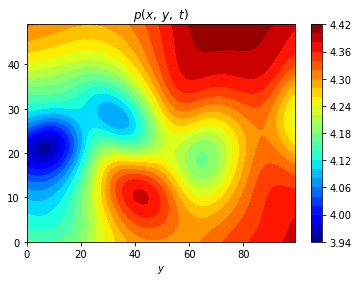

In [32]:
p_plot = p_out.data.cpu().numpy()
p_plot = np.reshape(p_plot, (50, 100))

fig, ax = plt.subplots()

plt.contourf(p_plot, levels=30, cmap='jet')
plt.colorbar()
#plt.show()

def animate(i):
    ax.clear()
    u_out, v_out, p_out, f_out, g_out = PINN.function(x_test, y_test, i*t_test)
    #u_plot = p_out.data.cpu().numpy()
    #u_plot = u_out.data.cpu().numpy()
    p_plot = p_out.data.cpu().numpy()
    p_plot = np.reshape(p_plot, (50, 100))
    cax = ax.contourf(p_plot, levels=20, cmap='jet')
    plt.xlabel(r'$x$')
    plt.xlabel(r'$y$')
    # plt.title(r'$p(x,\; y, \; t)$')
    # plt.title(r'$u(x,\; y, \; t)$')
    plt.title(r'$p(x, \; y, \; t)$')

# Call animate method
ani = animation.FuncAnimation(fig, animate, 20, interval=1, blit=False)
ani.save('p_field_lbfgs.gif')
#plt.close()
# Display the plot
plt.show()


MovieWriter ffmpeg unavailable; using Pillow instead.


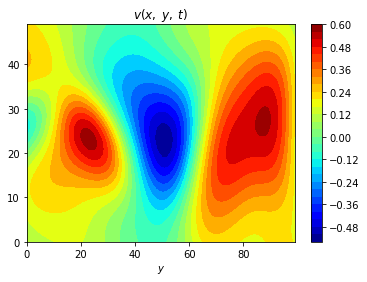

In [33]:
v_plot = v_out.data.cpu().numpy()
v_plot = np.reshape(v_plot, (50, 100))

fig, ax = plt.subplots()

plt.contourf(v_plot, levels=30, cmap='jet')
plt.colorbar()
#plt.show()

def animate(i):
    ax.clear()
    u_out, v_out, p_out, f_out, g_out = PINN.function(x_test, y_test, i*t_test)
    #u_plot = p_out.data.cpu().numpy()
    #u_plot = u_out.data.cpu().numpy()
    v_plot = v_out.data.cpu().numpy()
    v_plot = np.reshape(v_plot, (50, 100))
    cax = ax.contourf(v_plot, levels=20, cmap='jet')
    plt.xlabel(r'$x$')
    plt.xlabel(r'$y$')
    # plt.title(r'$p(x,\; y, \; t)$')
    # plt.title(r'$u(x,\; y, \; t)$')
    plt.title(r'$v(x, \; y, \; t)$')

# Call animate method
ani = animation.FuncAnimation(fig, animate, 20, interval=1, blit=False)
ani.save('v_field_lbfgs.gif')
#plt.close()
# Display the plot
plt.show()


MovieWriter ffmpeg unavailable; using Pillow instead.


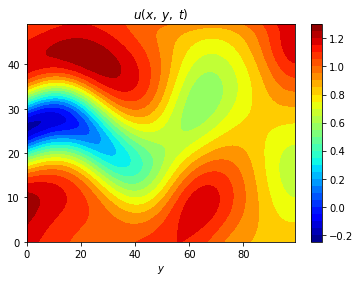

In [34]:
u_plot = u_out.data.cpu().numpy()
u_plot = np.reshape(u_plot, (50, 100))

fig, ax = plt.subplots()

plt.contourf(u_plot, levels=30, cmap='jet')
plt.colorbar()
#plt.show()

def animate(i):
    ax.clear()
    u_out, v_out, p_out, f_out, g_out = PINN.function(x_test, y_test, i*t_test)
    #u_plot = p_out.data.cpu().numpy()
    #u_plot = u_out.data.cpu().numpy()
    u_plot = u_out.data.cpu().numpy()
    u_plot = np.reshape(u_plot, (50, 100))
    cax = ax.contourf(u_plot, levels=20, cmap='jet')
    plt.xlabel(r'$x$')
    plt.xlabel(r'$y$')
    # plt.title(r'$p(x,\; y, \; t)$')
    # plt.title(r'$u(x,\; y, \; t)$')
    plt.title(r'$u(x, \; y, \; t)$')

# Call animate method
ani = animation.FuncAnimation(fig, animate, 20, interval=1, blit=False)
ani.save('u_field_lbfgs.gif')
#plt.close()
# Display the plot
plt.show()


Text(0, 0.5, 'Loss')

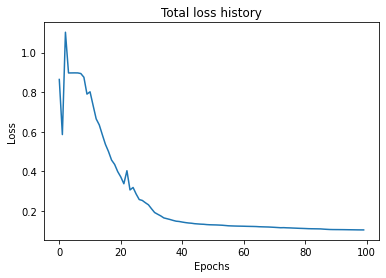

In [38]:
plt.plot(PINN.loss_history[:100])
# plt.plot(PINN.loss_history)
plt.title("Total loss history")
plt.xlabel("Epochs")
plt.ylabel("Loss")

Text(367.48863636363626, 0.5, 'Loss')

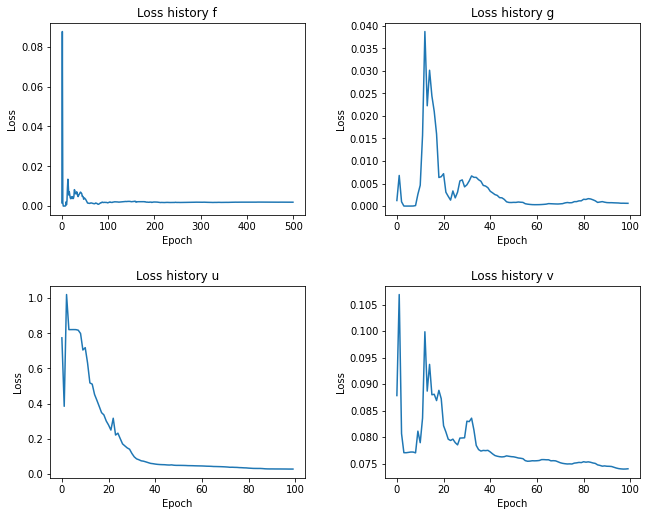

In [40]:
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(10, 8))
fig.tight_layout(pad=5.0)
ax1.plot(PINN.loss_history_f[:500])
ax1.set_title('Loss history f')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Loss')

ax2.plot(PINN.loss_history_g[:100])
ax2.set_title('Loss history g')
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Loss')

ax3.plot(PINN.loss_history_u[:100])
ax3.set_title('Loss history u')
ax3.set_xlabel('Epoch')
ax3.set_ylabel('Loss')

ax4.plot(PINN.loss_history_v[:100])
ax4.set_title('Loss history v')
ax4.set_xlabel('Epoch')
ax4.set_ylabel('Loss')

### Lid Driven Cavity Problem

In [23]:
N_train = 5000
nu = 0.01 # Reynold's number

data = scipy.io.loadmat('C:\\Users\\Administrator\\Documents\\research\\fluid-sim\\data\\2d_navierstokes.mat')

usol = data['usol'] # sqrt(N) x sqrt(N) x T
vsol = data['vsol'] # sqrt(N) x sqrt(N) x T
psol = data['psol'] # sqrt(N) x sqrt(N) x T

# cut off first entries from usol, vsol, and psol because it is empty
usol = usol[:, :89, 1:] # cut off an extra row in y dimension
vsol = vsol[:89, :, 1:] # cut off an extra row in x dimension 
psol = psol[:89, :89, 1:]

x = np.arange(0, 1, 1/90)[:89]
y = np.arange(0, 1, 1/90)[:89]
t = np.arange(0, 4, 0.01).reshape(-1, 1)[:399]

X, Y, T = np.meshgrid(x, y, t, indexing='ij')
X = X.reshape(-1, 1)
Y = Y.reshape(-1, 1)
T = T.reshape(-1, 1)
X_star = np.concatenate((X, Y, T), axis=1).reshape(89, 89, 399, 3)

N = X_star.shape[0] * X_star.shape[1]
T = t.shape[0]

x_bc = np.concatenate((X_star[:, 0, :], X_star[:, -1, :], X_star[0, 1:-1, :], X_star[-1, 1:-1, :]), axis=0)
x_ic = X_star[:, :, 0].reshape(N, 3) # positions
x_bc = x_bc.reshape(x_bc.shape[0] * x_bc.shape[1], x_bc.shape[2])
x_icbc = np.vstack((x_ic, x_bc))

# usol = np.reshape(usol, (N, T)) # N x T
# vsol = np.reshape(vsol, (N, T)) # N x T
# psol = np.reshape(psol, (N, T)) # N x T

# XX = np.tile(X_star[:, 0:1], (1, usol.shape[1])) # N x T
# YY = np.tile(X_star[:, 1:2], (1, usol.shape[1])) # N x T
# TT = np.tile(t, (1, X_star.shape[0])).T # N x T

# flatten all inputs
# x = XX.flatten()[:, None] # NT x 1
# y = YY.flatten()[:, None] # NT x 1
# t = TT.flatten()[:, None] # NT x 1

# u = usol.flatten()[:, None] # NT x 1
# v = vsol.flatten()[:, None] # NT x 1
# p = psol.flatten()[:, None] # NT x 1

# extract initial and boundary conditions
u_ic = usol[:, :, 0]
u_bc = np.concatenate((usol[:, 0, :], usol[:, -1, :], usol[0, 1:-1, :], usol[-1, 1:-1, :]), axis=0)
u_icbc = np.hstack((u_ic.flatten(), u_bc.flatten())).reshape(-1, 1)

v_ic = vsol[:, :, 0]
v_bc = np.concatenate((vsol[:, 0, :], vsol[:, -1, :], vsol[0, 1:-1, :], vsol[-1, 1:-1, :]), axis=0)
v_icbc = np.hstack((v_ic.flatten(), v_bc.flatten())).reshape(-1, 1)

idx = np.random.choice(u_icbc.shape[0], N_train, replace=False)
x_train = x_icbc[idx][:, 0]
y_train = x_icbc[idx][:, 1]
t_train = x_icbc[idx][:, 2]

u_train = u_icbc[idx, :]
v_train = v_icbc[idx, :]
# p_train = p[idx, :]

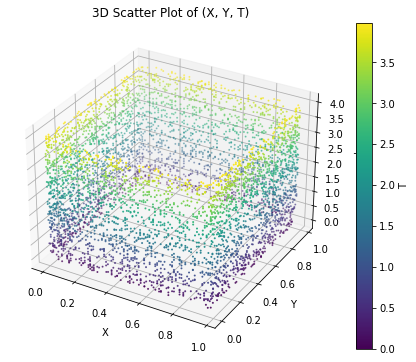

In [26]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

x = np.arange(0, 1, 1/90)[:89]
y = np.arange(0, 1, 1/90)[:89]
t = np.arange(0, 4, 0.01).reshape(-1, 1)[:399]
X, Y, T = np.meshgrid(x, y, t, indexing='ij')
X = X.reshape(-1, 1)
Y = Y.reshape(-1, 1)
T = T.reshape(-1, 1)
X_star = np.concatenate((X, Y, T), axis=1).reshape(89, 89, 399, 3)

x_bc = np.concatenate((X_star[:, 0, :], X_star[:, -1, :], X_star[0, 1:-1, :], X_star[-1, 1:-1, :]), axis=0)
x_bc = x_bc.reshape(x_bc.shape[0] * x_bc.shape[1], x_bc.shape[2])

idx = np.random.choice(x_bc.shape[0], N_train, replace=False)

x_bc = x_bc[idx]
# Extracting x, y, and t
x_icbc = x_bc[:, 0]
y_icbc = x_bc[:, 1]
t_icbc = x_bc[:, 2]

fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(111, projection='3d')

# Plotting the points
scatter = ax.scatter(x_icbc, y_icbc, t_icbc, c=t_icbc, cmap='viridis', s=0.5)

# Adding labels and title
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('T')
ax.set_title('3D Scatter Plot of (X, Y, T)')

# Adding color bar
cbar = fig.colorbar(scatter)
cbar.set_label('T')

plt.show()

In [14]:
PINN = NS(x_train, y_train, t_train, u_train, v_train)
PINN.train()

Iteration: 1, Loss: 0.180606
Iteration: 2, Loss: 1.306456
Iteration: 3, Loss: 0.063128
Iteration: 4, Loss: 0.058281
Iteration: 5, Loss: 0.045591
Iteration: 6, Loss: 0.044647
Iteration: 7, Loss: 0.044639
Iteration: 8, Loss: 0.044673
Iteration: 9, Loss: 0.044683
Iteration: 10, Loss: 0.044659
--------Switching optimizer--------
Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    eps: 1e-08
    lr: 0.1
    weight_decay: 0
)
LBFGS (
Parameter Group 0
    history_size: 50
    line_search_fn: strong_wolfe
    lr: 1
    max_eval: 50000
    max_iter: 200000
    tolerance_change: 1.1102230246251565e-16
    tolerance_grad: 1e-05
)
-----------------------------------
Iteration: 11, Loss: 0.044614
Iteration: 12, Loss: 0.044601
Iteration: 13, Loss: 0.044527
Iteration: 14, Loss: 0.044507
Iteration: 15, Loss: 0.044491
Iteration: 16, Loss: 0.044475
Iteration: 17, Loss: 0.044410
Iteration: 18, Loss: 0.044064
Iteration: 19, Loss: 0.043878
Iteration: 20, Loss: 0.044512
Iteration: 21, L

In [15]:
PINN.net.eval()

DNN(
  (model): Sequential(
    (layer_0): Linear(in_features=3, out_features=20, bias=True)
    (activation_0): Tanh()
    (layer_1): Linear(in_features=20, out_features=20, bias=True)
    (activation_1): Tanh()
    (layer_2): Linear(in_features=20, out_features=20, bias=True)
    (activation_2): Tanh()
    (layer_3): Linear(in_features=20, out_features=20, bias=True)
    (activation_3): Tanh()
    (layer_4): Linear(in_features=20, out_features=20, bias=True)
    (activation_4): Tanh()
    (layer_5): Linear(in_features=20, out_features=20, bias=True)
    (activation_5): Tanh()
    (layer_6): Linear(in_features=20, out_features=2, bias=True)
  )
)

In [35]:
x_test = X_star[:, 0:1, :, 0]
y_test = X_star[:, 1:2, :, 1]
t_test = np.ones((x_test.shape[0], x_test.shape[1]))

x_test = torch.tensor(x_test, dtype=torch.float32, requires_grad=True).to(device)
y_test = torch.tensor(y_test, dtype=torch.float32, requires_grad=True).to(device)
t_test = torch.tensor(t_test, dtype=torch.float32, requires_grad=True).to(device)

In [34]:
x_test.shape

torch.Size([89, 1, 399])

In [17]:
u_out, v_out, p_out, f_out, g_out = PINN.function(x_test, y_test, t_test)

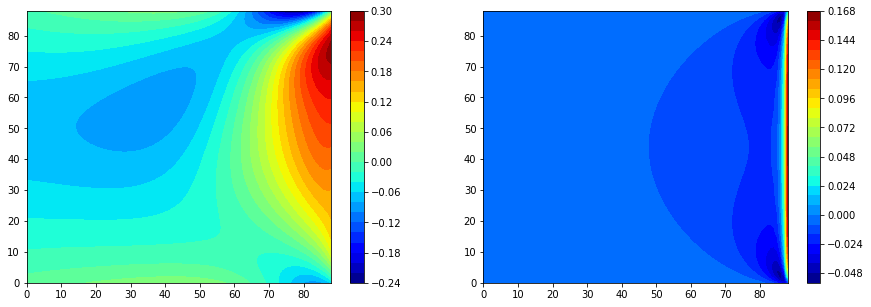

MovieWriter ffmpeg unavailable; using Pillow instead.


In [18]:
u_plot = u_out.data.cpu().numpy()
u_plot = np.reshape(u_plot, (89, 89))
usol = np.reshape(usol, (89, 89, 399))

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

h = ax1.contourf(u_plot, levels=30, cmap='jet')
fig.colorbar(h)

h = ax2.contourf(usol[:, :, 0], levels=30, cmap='jet')
fig.colorbar(h)
plt.show()

def animate(i):
    ax1.clear()
    ax2.clear()
    u_out, v_out, f_out, g_out, h_out = PINN.function(x_test, y_test, 0.01*i*t_test)
    u_plot = u_out.data.cpu().numpy()
    u_plot = np.reshape(u_plot, (89, 89))
    cax = ax1.contourf(u_plot, levels=20, cmap='jet')
    cax = ax2.contourf(usol[:, :, i], levels=20, cmap='jet')
    ax1.set_xlabel(r'$x$')
    ax1.set_ylabel(r'$y$')
    ax2.set_xlabel(r'$x')
    ax2.set_ylabel(r'$y$')
    ax1.set_title(r'Predicted $u(x, \; y, \;t)$')
    ax2.set_title(r'Ground truth $u(x, \;y, \;t)$')

ani = animation.FuncAnimation(fig, animate, 50, interval=1, blit=False)
ani.save('u_field_ns.gif')
plt.show()
    

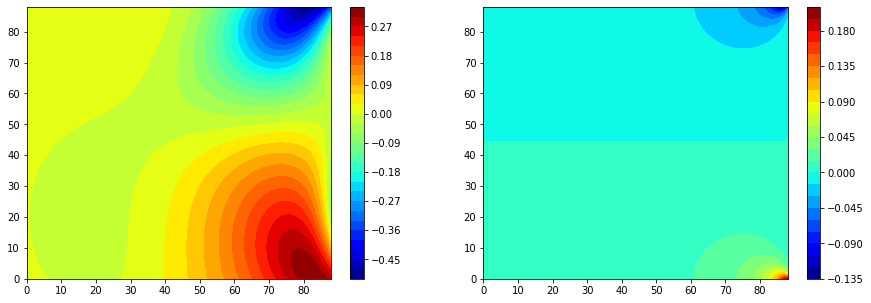

MovieWriter ffmpeg unavailable; using Pillow instead.


In [19]:
v_plot = v_out.data.cpu().numpy()
v_plot = np.reshape(v_plot, (89, 89))
vsol = np.reshape(vsol, (89, 89, 399))

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

h = ax1.contourf(v_plot, levels=30, cmap='jet')
fig.colorbar(h)

h = ax2.contourf(vsol[:, :, 0], levels=30, cmap='jet')
fig.colorbar(h)
plt.show()

def animate(i):
    ax1.clear()
    ax2.clear()
    u_out, v_out, f_out, g_out, h_out = PINN.function(x_test, y_test, 0.01*i*t_test)
    v_plot = v_out.data.cpu().numpy()
    v_plot = np.reshape(v_plot, (89, 89))
    cax = ax1.contourf(v_plot, levels=20, cmap='jet')
    cax = ax2.contourf(vsol[:, :, i], levels=20, cmap='jet')
    ax1.set_xlabel(r'$x$')
    ax1.set_ylabel(r'$y$')
    ax2.set_xlabel(r'$x')
    ax2.set_ylabel(r'$y$')
    ax1.set_title(r'Predicted $v(x, \; y, \;t)$')
    ax2.set_title(r'Ground truth $v(x, \;y, \;t)$')

ani = animation.FuncAnimation(fig, animate, 50, interval=1, blit=False)
ani.save('v_field_ns.gif')
plt.show()
    

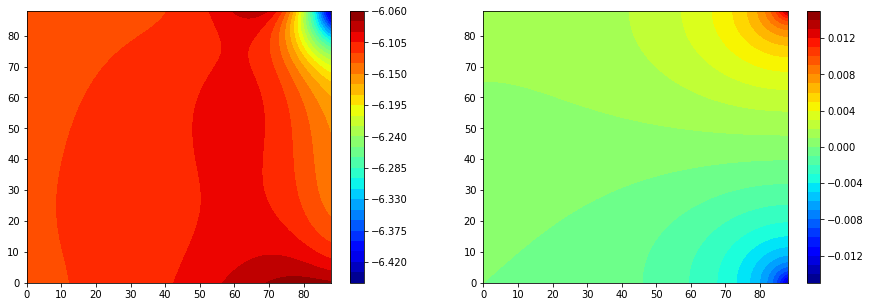

MovieWriter ffmpeg unavailable; using Pillow instead.


In [20]:
p_plot = p_out.data.cpu().numpy()
p_plot = np.reshape(p_plot, (89, 89))
psol = np.reshape(psol, (89, 89, 399))

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

h = ax1.contourf(p_plot, levels=30, cmap='jet')
fig.colorbar(h)

h = ax2.contourf(psol[:, :, 0], levels=30, cmap='jet')
fig.colorbar(h)
plt.show()

def animate(i):
    ax1.clear()
    ax2.clear()
    u_out, v_out, f_out, g_out, h_out = PINN.function(x_test, y_test, 0.01*i*t_test)
    p_plot = p_out.data.cpu().numpy()
    p_plot = np.reshape(p_plot, (89, 89))
    cax = ax1.contourf(p_plot, levels=20, cmap='jet')
    cax = ax2.contourf(psol[:, :, i], levels=20, cmap='jet')
    ax1.set_xlabel(r'$x$')
    ax1.set_ylabel(r'$y$')
    ax2.set_xlabel(r'$x')
    ax2.set_ylabel(r'$y$')
    ax1.set_title(r'Predicted $p(x, \; y, \;t)$')
    ax2.set_title(r'Ground truth $p(x, \;y, \;t)$')

ani = animation.FuncAnimation(fig, animate, 50, interval=1, blit=False)
ani.save('p_field_ns.gif')
plt.show()
    

Text(0, 0.5, 'Loss')

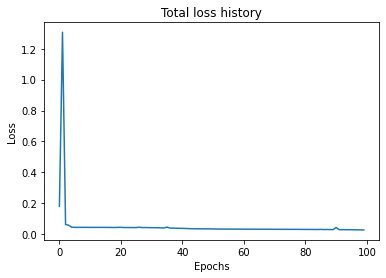

In [21]:
plt.plot(PINN.loss_history[:100])
# plt.plot(PINN.loss_history)
plt.title("Total loss history")
plt.xlabel("Epochs")
plt.ylabel("Loss")

Text(367.48863636363626, 0.5, 'Loss')

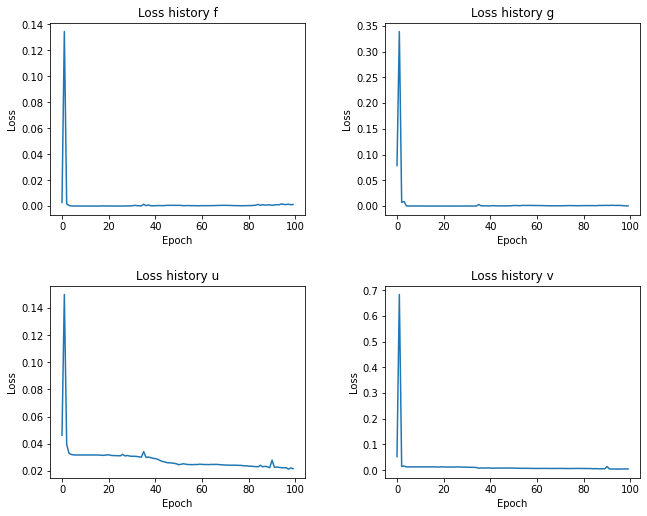

In [22]:
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(10, 8))
fig.tight_layout(pad=5.0)
ax1.plot(PINN.loss_history_f[:100])
ax1.set_title('Loss history f')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Loss')

ax2.plot(PINN.loss_history_g[:100])
ax2.set_title('Loss history g')
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Loss')

ax3.plot(PINN.loss_history_u[:100])
ax3.set_title('Loss history u')
ax3.set_xlabel('Epoch')
ax3.set_ylabel('Loss')

ax4.plot(PINN.loss_history_v[:100])
ax4.set_title('Loss history v')
ax4.set_xlabel('Epoch')
ax4.set_ylabel('Loss')